In [2]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from keras.callbacks import History 
## for Deep-learing:
import keras
from keras import models
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
import itertools
from keras.layers import LSTM
from keras.layers import Dropout
from keras import regularizers
from keras.regularizers import L1L2
from sklearn.preprocessing import MinMaxScaler
from keras.layers import GaussianNoise

Using TensorFlow backend.


In [3]:
#sc=MinMaxScaler(feature_range=(0,1))
def Scale_X(dataset,lag):#return the 3 D array for training and 1 D to actual value.
    data=dataset.iloc[:,1:2].values
    data=sc.fit_transform(data)
    X_train=[]
    y_train=[]
    window_size=lag
    train_num=len(data)
    for i in range(window_size,train_num-1):
        X_train.append(data[i-window_size:i,0])
        y_train.append(data[i,0])
    X_train,y_train=np.array(X_train),np.array(y_train)
    X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    return X_train, y_train

In [9]:
def build_model(unit=200, GNoise=0.01,Drpout=0.3, l2=0.01):
    model = models.Sequential()
    '''
    L2 regularizer used to prevent the overfitting in some cases
    '''
    if l2==0.0:
        model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    else:
        model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1),
                   kernel_regularizer=regularizers.l2(l2)))
    '''
    Adding noise to an underconstrained neural network model with
    a small training dataset can have a regularizing effect and reduce overfitting.
    On my experiments the best GaussianNoise (for starting point)to make prediction on cycles 90 to 110 is 0.01, 
    and 0.1 (for starting point)to make prediction on cycles 80,70,60. 
    '''        
    model.add(GaussianNoise(GNoise))
    model.add(Dropout(Drpout))
              
    model.add(LSTM(units=unit, return_sequences=True))
    model.add(Dropout(Drpout))
              
    model.add(LSTM(units=unit, return_sequences=True))
    model.add(Dropout(Drpout))
    
    model.add(LSTM(units=unit))
    model.add(Dropout(Drpout))
    
    model.add(Dense(units=1))
              
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])
    return model             

In [10]:
df=pd.read_csv("B0005_discharge.csv")
#Dataset contains 168 cycles
features=['cycle','Capacity']
df=df[features]
dataset=df
RuL=124
#Select the size of the training dataset
size_train=111
#Split the dataset into training dataset and test dataset
data_train=dataset[(dataset['cycle']<size_train)]
data_test=dataset[(dataset['cycle']>=size_train)]
#Convert the data to victors
data_set_train=data_train.iloc[:,1:2].values
data_set_test=data_test.iloc[:,1:2].values
#Scaling the data to work with LSTM
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)
#Defined the Window size (Lag)
window_size=10
#Create new two Lists: one for the features(num of col = window size) and one for the target
X_train=[]
y_train=[]
for i in range(window_size,size_train-1):
    X_train.append(data_set_train[i-window_size:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [ ]:
#unit=200, GNoise=0.01,Drpout=0.3, l2=0.01
L2=False # if the model used l2 or not 
regress=build_model()
# batch_size=32
hist=regress.fit(X_train,y_train,epochs=150,batch_size=len(data_train))

In [12]:
# The number of cycles need to be predicted 
num_cycle_pred=10

regress.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 200)           161600    
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 10, 200)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10, 200)           320800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 10, 200)           320800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 200)           0         
__________

<p> We trained our model to be able to predict the Capacity at cycle t+1 based on the previous number of cycle that equal to the window size.</p>
<p> Therefore, to predict each capacity of each cycle, we will need the previous number of cycles (that eqaul to the window size) from our training dataset to predict the next cycle.</p>

In [ ]:
####                      predictions                                     ###
#In our case we only have the training dataset (on real time system we do not have information
# about the next cycles)
#On time series data the next prediction depend on last window in the training dataset (seq data)
#in order to predict the next cycle we need the last  cycels that equal to the window size
# from the training dataset to make prediction.
#firstly, we predict the next 10 cycles,then we add these cycles to the training dataset
### After that, we rebuild the model with the new prediction cycles t+1,t+2,t3,t4,t5 and so on. 
#and we do again to predict the next 10th cycles and so on.

while(len(data_train)<168):
    #Get the Training datatset from data_train dataset, declare a new varibale called data_total. 
    ''' Copy the training data to the new dataset to predict next T cycles'''
    data_total=data_train['Capacity']
    # Create new list for prediction
    pred_list=[]
    ''' Take the last cycles (which is equal the window-size) from data_tolat list and add it to the pred_list'''
    pred_list=data_total[len(data_total)-window_size:]
    #Make prediction to the next 10 cycles
    for i in range(num_cycle_pred):
        ''' predict next cycle
                - convert the list of inputs to victor
        '''
        inputs=pred_list[len(pred_list)-window_size-i:].values
        inputs=inputs.reshape(-1,1)
        #scale the inputs
        inputs=sc.transform(inputs)
        X_test=[]
        X_test.append(inputs[i:window_size+i,0])
        X_test=np.array(X_test)
        X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
        #Make prediction for one cycle
        pred=regress.predict(X_test)
        pred=sc.inverse_transform(pred)
        pred=pred[:,0]
        pred=float(pred)
        print('L2 '+str(pred))
        '''
        We know that the Capacity will reduce over the time, but after preprocessing the data
        we found that the capacity in some cycles increased over the time, in this case, we can 
        predict only the next 10 cycles. To solve this problem we used L2 and GaussianNoise 
        to reduce the overfitting.
        '''
        ####### End prediction one cycle##########
        ## get the length of pred_list 
        y=pred_list.index[len(pred_list)-1]
        #Convert pred to time Series
        s1 = pd.Series(float(pred),index=[y+1])
        # Add (Concat) a new prediction to pred_list to predict next cycle
        pred_list=pd.concat([pred_list,s1])
        
    # convert the new prodiction to time series platform and add it to the training dataset
        #Convert one cycle prediction to time Series platform
        j=len(data_train)+1
        s2=pd.Series([int(j),float(pred)],index=['cycle','Capacity'])
        #concat the prediction cycle to the training dataset
        data_train=data_train.append(s2,ignore_index=True)
    # Scale the traing dataset, After cycles prediction
    X_train,y_train=Scale_X(data_train,window_size)# Scaling the training dataset with new cycles.
    # Rebuild the Model
    regress=build_model()
    hist=regress.fit(X_train,y_train,epochs=100,batch_size=len(data_train))

In [14]:
len(data_train)

170

In [20]:
check=data_train
data_train=data_train[(data_train['cycle']>=1)&((data_train['cycle']<=168))]
dataset=dataset[(dataset['cycle']>=1)&((dataset['cycle']<=168))]

Actual=dataset[((dataset['cycle']>size_train))]
prediction=data_train[((data_train['cycle']>size_train))]
rmse = np.sqrt(mean_squared_error(Actual['Capacity'], prediction['Capacity']))
print('Test RMSE: %.3f' % rmse)
#r2=metrics.r2_score(Actual['Capacity'],prediction['Capacity'])
#print(r2)

Test RMSE: 0.031


In [16]:
actual=0
pred=0
Afil=0
Pfil=0
a=Actual['Capacity'].values
b=prediction['Capacity'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.4:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.4:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+size_train))
print("The prediction fail at cycle number: "+ str(Pfil+size_train))

RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 124
The prediction fail at cycle number: 123
The error of RUL= -1 Cycle(s)


Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 111, window-size= 10, RULe= -1')

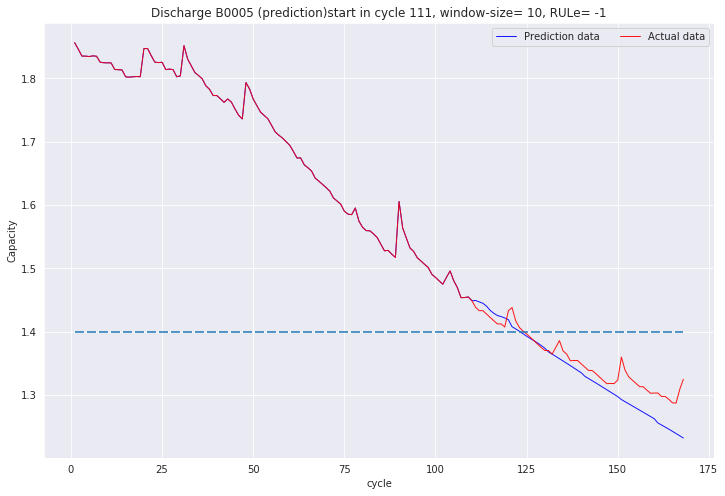

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid") 
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue',linewidth=1, alpha=0.9)
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red',linewidth=1, alpha=0.9)
#plt.plot(pred)
#Draw threshold
plt.plot([1.0,168], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('Capacity')
# make x-axis ticks legible
plt.legend(loc='upper right', ncol=2,)
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle '+ str(size_train)+', window-size= '+str(window_size)
         + ', RULe= '+ str(RULerror))